In [ ]:
#Phase 3: Modeling and Error Analysis

In [ ]:
import tensorflow as tf
tf.__version__

!sudo pip3 install keras

#from tensorflow.python.keras.engine.sequential import Sequential

#from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import os
import json
import pickle
import pandas as pd
import numpy as np
#from tensorflow.keras import models, layers
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
#from tensorflow.keras.optimizers import Adam,RMSprop,SGD
#import tensorflow.keras.backend as k
#import tensorflow.keras as keras
#import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv3D,UpSampling2D,ReLU,Dropout
from tensorflow.keras.layers import Layer
import matplotlib.image as mpimg
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt



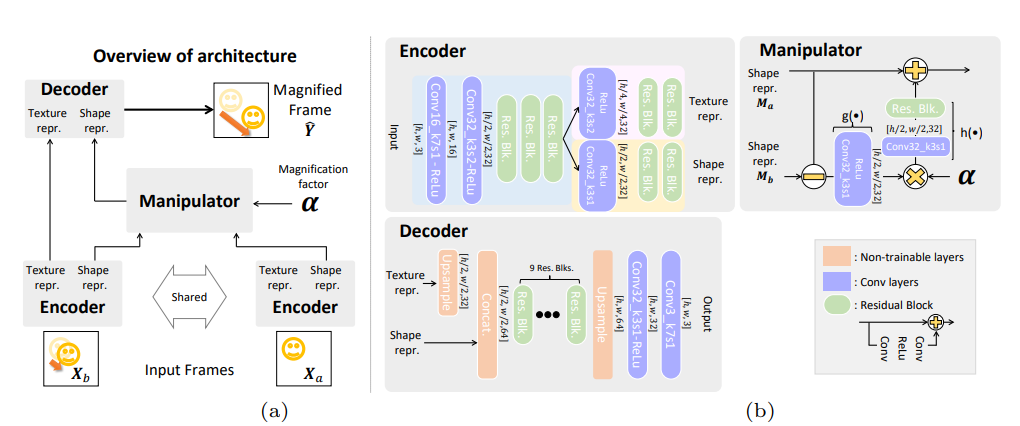

In [ ]:
#Residual of Layer

class Residual(Layer):
   #def __init__(self, filters,kernel,**kwargs): packs all of the keyword arguments used in any given call to __init__ into a dict
   #super().__init__(**kwargs): expands them into keyword arguments again.
  def __init__(self, filters,kernel,**kwargs):
        super(Residual, self).__init__(**kwargs)
        self.trainable = True
        self.filters = filters
        self.kernel = kernel
        self.Conv1 = Conv2D( self.filters, 3, padding="same")
        self.Conv2 = Conv2D( self.filters, 3, padding="same")
        self.BatchNorm1 = BatchNormalization()
        self.BatchNorm2 = BatchNormalization()


  def call(self, x):        
        self.first = x
        x = self.BatchNorm1(x)        
        x = self.Conv1(x)
        x = self.BatchNorm2(x)
        x = self.Conv2(x)        
        residual =  Add()([x, self.first])
        x =  Activation("relu")(residual)
        return x

  def compute_output_shape(self, input_shape):
        return input_shape




 

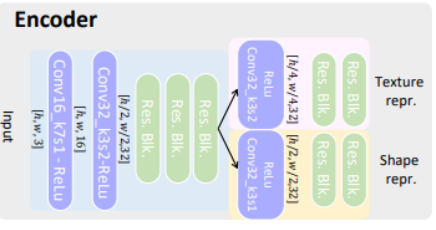

In [ ]:
#Encoder of Layer
class Encoder(Layer):
  def __init__(self,kernel_nums=[16,32],kernel_size=[(7,7),(3,3)],strides=[(1,1),(2,2)]):
    super().__init__()
    self.trainable = True
    self.kernel1 = kernel_size[0]
    self.kernel2 = kernel_size[1]
    self.filters1 = kernel_nums[0]
    self.filters2 = kernel_nums[1]
    self.stride1 = strides[0]
    self.stride2 = strides[1]

    # creating 3 residual 
    self.R1 = Residual(self.filters2,self.kernel2)
    self.R2 = Residual(self.filters2,self.kernel2)
    self.R3 = Residual(self.filters2,self.kernel2)

    # convolution_16_k7s1 
    self.conv1 = Conv2D(filters=self.filters1,kernel_size=self.kernel1,strides=self.stride1,activation='relu',padding='same')
    # convolution_32_k3s2 
    self.conv2 = Conv2D(filters=self.filters2,kernel_size=self.kernel2,strides=self.stride2,activation='relu',padding='same')

     # Residual Texture Representation
    self.Residualtexture1 = Residual(self.filters2,self.kernel2)
    self.Residualtexture2 = Residual(self.filters2,self.kernel2)

    # Residual Shape Representation
    self.ResidualShape1 = Residual(self.filters2,self.kernel2)
    self.ResidualShape2 = Residual(self.filters2,self.kernel2)

    # Texture Representation - convolution_32_k3s2 
    self.convTextureRepr = Conv2D(filters=self.filters2,kernel_size=self.kernel2,strides=self.stride2,activation='relu',padding='same')

    #  Shape Representation - convolution_32_k3s1 
    self.convShapeRepr = Conv2D(filters=self.filters2,kernel_size=self.kernel2,strides=self.stride1,activation='relu',padding='same')
  

   
  def call(self,data):
      x = data
      x=self.conv1(x)
      x=self.conv2(x)
      x=self.R1(x)
      x=self.R2(x)
      x_final_Residual=self.R3(x)

      # obtaining texture representation
      x_texture= self.convTextureRepr(x_final_Residual)
      x_texture= self.Residualtexture1(x_texture)
      textureoutput = self.Residualtexture2(x_texture)

      # obtaining shape representation
      x_shape= self.convShapeRepr(x_final_Residual)
      x_shape =self.ResidualShape1(x_shape)
      shapeoutput= self.ResidualShape2(x_shape)

      return textureoutput, shapeoutput


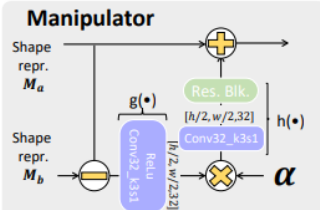

In [ ]:
#Manipulator of Layer
class Manipulator(Layer):
  def __init__(self,kernelSize=(3,3),  filters=32, stride=(1,1)):
    super().__init__()
    self.trainable = True
    self.kernel = kernelSize
    self.filters= filters
    self.stride = stride

    # Residual
    self.residual = Residual(self.filters,self.kernel)

    # convolution_32_k3s1 
    self.conv1= Conv2D(self.filters, self.kernel, self.stride,activation = 'relu', padding = 'same')

    # convolution_32_k3s1 
    self.conv2= Conv2D(self.filters, self.kernel, self.stride,activation = 'relu', padding = 'same')


  def call(self,data):

    self.Ma=data[0]
    self.Mb=data[1]
    self.alpha= data[2]

    self.diff = tf.abs(self.Ma-self.Mb)

    input = self.diff
    x = self.conv1(input)
    x= self.alpha*x
    x= self.conv2(x)
    x= self.residual(x)
    manipulator_output = x+self.Ma
    return manipulator_output

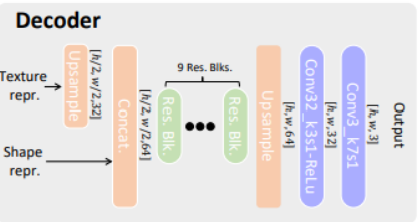

In [ ]:
#Decoder of Layer
class Decoder(Layer):
  def __init__(self,kernelSize=[(3,3),(7,7)],filters=[32,3],stride=(1,1)):
    super().__init__()
    self.trainable = True
    self.filter1= filters[0]
    self.filter2= filters[1]
    self.kernel1 =kernelSize[0]
    self.kernel2 = kernelSize[1]
    self.stride=stride

    # creating 9 residual 
    self.R1 = Residual(64,self.kernel1)
    self.R2 = Residual(64,self.kernel1)
    self.R3 = Residual(64,self.kernel1)
    self.R4 = Residual(64,self.kernel1)
    self.R5 = Residual(64,self.kernel1)
    self.R6 = Residual(64,self.kernel1)
    self.R7 = Residual(64,self.kernel1)
    self.R8 = Residual(64,self.kernel1)
    self.R9 = Residual(64,self.kernel1)

    self.upsamplingOfTextureRepr = UpSampling2D( size=(2, 2),  interpolation='nearest')
    self.upSampling = UpSampling2D( size=(2, 2),  interpolation='nearest')

    #convolution_32_k3s1 
    self.Conv1= Conv2D(self.filter1, self.kernel1, self.stride,activation = 'relu', padding = 'same')

    #convolution_3_k7s1 
    self.Conv2= Conv2D(self.filter2, self.kernel2, self.stride,activation = 'relu', padding = 'same')



  def call(self,data):
      self.textureRepr = data[0]
      self.shapeRepr= data[1]
      # Upsampling of Texture Representation
      x= self.upsamplingOfTextureRepr(self.textureRepr)
      # Concate Output of Upsampling of Texture Representation and Shape Representation
      x = tf.concat([x,self.shapeRepr],axis=-1)

      #Creating 9 Residual
      x= self.R1(x)
      x= self.R2(x)
      x= self.R3(x)
      x= self.R4(x)
      x= self.R5(x)
      x= self.R6(x)
      x= self.R7(x)
      x= self.R8(x)
      x= self.R9(x)

      # Upsampling of Output of Residuals
      x= self.upSampling(x)  

      # convolution of Output of Upsampling 
      x= self.Conv1(x)

      # convolution of Output of convolution of 32 filter 
      final_output = self.Conv2(x)
      return final_output